# Предсказание восстановления металлов из руды

Необходимо подготовить модель которая может предсказать коэффициент восстановления золота из золотосодержащей руды по данным с параметрами добычи и очистки. 


## Подготовка данных

 Откройте файлы и изучите их.
  Проверьте, что эффективность обогащения рассчитана правильно. 
  Проанализируйте признаки, недоступные в тестовой выборке.
  Проведите предобработку данных.

Наименование признаков:
- [этап].[тип_параметра].[название_параметра]


- Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики


- Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

C = rougher.output.concentrate_au
F = rougher.input.feed_au
rougher.output.recovery
T = rougher.output.tail_au

recovery = (C * (F-T) / (F * (C-T))) * 100%

- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer


In [ ]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [ ]:
data_train.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [ ]:
f'data_train: {data_train.shape}, data_test: {data_test.shape}, data_full: {data_full.shape}'

'data_train: (14149, 87), data_test: (5290, 53), data_full: (19439, 87)'

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [ ]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Необходимо проверить, правильно ли подсчитано ***recovery***. Формула для расчёта:


recovery = (C * (F-T) / (F * (C-T))) * 100%


C — доля золота в концентрате после флотации/очистки;
F — доля золота в сырье/концентрате до флотации/очистки;
T — доля золота в отвальных хвостах после флотации/очистки.

C = rougher.output.concentrate_au
F = rougher.input.feed_au
rougher.output.recovery
T = rougher.output.tail_au

In [ ]:
data_train['rec_calc'] = (
    (data_train['rougher.output.concentrate_au'] * (data_train['rougher.input.feed_au'] - data_train['rougher.output.tail_au'])) / 
    (data_train['rougher.input.feed_au'] * (data_train['rougher.output.concentrate_au'] - data_train['rougher.output.tail_au'])) *
    100)

In [ ]:
data_train['rec_calc'].head(5)

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rec_calc, dtype: float64

In [ ]:
data_train['rougher.output.recovery'].head(5)

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

In [ ]:
(abs(data_train['rougher.output.recovery'] - data_train['rec_calc']) < 0.0001).sum() == len(data_train)

True

Подсчёт по формуле и значения в таблице совпадают.

In [ ]:
delta = set(data_train.columns) - set(data_test.columns)
delta

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rec_calc',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'roug

Сравнивая количество столбцов в тестовой и тренировочной выборках можно сделать вывод что в тестовой выборке отсутствуют выходные параметры для всех трёх этапов.

In [ ]:
data_train.isnull().sum().sum()

4100

In [ ]:
data_train.isnull().sum().sort_values(ascending=False).head(40)

secondary_cleaner.output.tail_sol             1605
rougher.state.floatbank10_e_air                436
rougher.input.floatbank11_xanthate             428
primary_cleaner.output.concentrate_sol         286
secondary_cleaner.state.floatbank2_a_air       217
final.output.concentrate_sol                   211
rougher.input.feed_size                        144
final.output.tail_pb                           100
rougher.input.feed_pb                          100
primary_cleaner.input.xanthate                 100
primary_cleaner.output.concentrate_pb           86
rougher.input.feed_sol                          78
primary_cleaner.output.tail_sol                 46
rougher.input.floatbank11_sulfate               36
primary_cleaner.input.depressant                32
rougher.input.floatbank10_sulfate               29
rougher.output.concentrate_sol                  22
secondary_cleaner.state.floatbank2_b_air        21
primary_cleaner.input.sulfate                   20
primary_cleaner.output.tail_pb 

In [ ]:
data_train.isnull().sum().sort_values(ascending=False)['rougher.state.floatbank10_e_air']

436

In [ ]:
data_train[pd.isnull(data_train['secondary_cleaner.output.tail_sol'])].isnull().sum().sum()

2156

In [ ]:
pd.isnull(data_train['secondary_cleaner.output.tail_sol']).sum()

1605

In [ ]:
data_train[pd.isnull(data_train['rougher.state.floatbank10_e_air'])].isnull().sum().sum()

493

In [ ]:
len(data_train.dropna())

11017

После проверки на пропуски можно заметить что общее число пропущенных значений - 4100 они сосредоточены в 3132 строках из . Это значит что чаще всего на строку приходится только одно пропущенное значение. Больше всего пропусков расположено в столбце ***secondary_cleaner.output.tail_sol***.

Для борьбы с пропусками есть три основных варианта - удалить строки с пропусками, заменить пропуски близкими значениями, удалить столбец в котором слишком много пропусков.

In [ ]:
data_train.loc[120:135, 'secondary_cleaner.output.tail_sol']

120    12.435482
121    12.832229
122    12.363726
123     4.843082
124     0.000000
125     3.079691
126    11.835476
127    12.260346
128    12.186020
129    11.620894
130     1.788792
131    12.231032
132    13.104183
133    13.699427
134    13.561395
135    13.370898
Name: secondary_cleaner.output.tail_sol, dtype: float64

<AxesSubplot:>

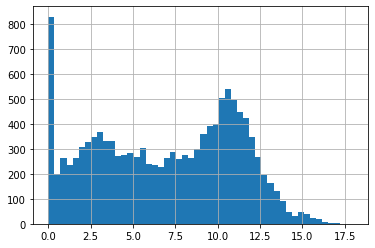

In [ ]:
data_train['secondary_cleaner.output.tail_sol'].hist(bins=50)

C учётом того что систему в данных определить трудно, наиболее логичным кажется решение удалить все строки с пропусками.

In [ ]:
data_train = data_train.dropna()

In [ ]:
data_train.duplicated().sum()

0

Автоматическая проверка дубликаты не выявила.

In [ ]:
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%d %H:%M:%S')
data_full['date'] = pd.to_datetime(data_full['date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
#data_train = data_train.drop('rec_calc', axis = 1)

Изменил формат данных в столбце с датой. Удалил столбец с расчётным значением 'rec_calc'.

# Вывод

Загрузил данные. У нас есть общий набор данных который уже заранее разбит на тестовую и тренировочную выборки. При этом в тестовой выборке отсутствуют столбцы с выходными данными. Формулы посчитаны корректно. В данных были пропуски, которые я удалил.

## Анализ данных

Нужно посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки (rougher.input, rougher.output, final.output). 
Так же нужно сравнить распределение размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
В конце нужно исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах и сделать выводы.

Text(0.5, 1.0, 'Concentrate Pb')

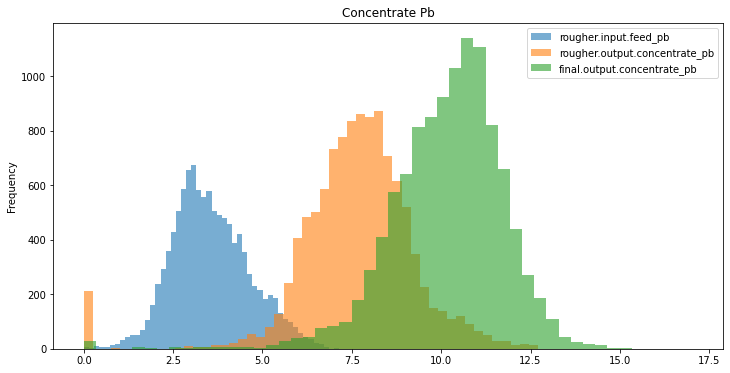

In [ ]:
data_train['rougher.input.feed_pb'].plot(kind = 'hist', bins=50, figsize = (12, 6), legend = True, alpha=0.6)
data_train['rougher.output.concentrate_pb'].plot(kind = 'hist', bins=50, legend = True, alpha=0.6)
data_train['final.output.concentrate_pb'].plot(kind = 'hist', bins=50, legend = True, alpha=0.6)
plt.title('Concentrate Pb')

Text(0.5, 1.0, 'Concentrate Ag')

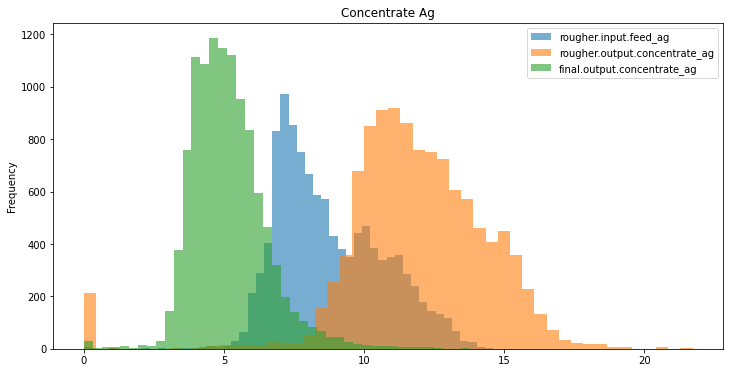

In [ ]:
data_train['rougher.input.feed_ag'].plot(kind = 'hist', bins=50, figsize = (12, 6), legend = True, alpha=0.6)
data_train['rougher.output.concentrate_ag'].plot(kind = 'hist', bins=50, legend = True, alpha=0.6)
data_train['final.output.concentrate_ag'].plot(kind = 'hist', bins=50, legend = True, alpha=0.6)
plt.title('Concentrate Ag')

Text(0.5, 1.0, 'Concentrate Au')

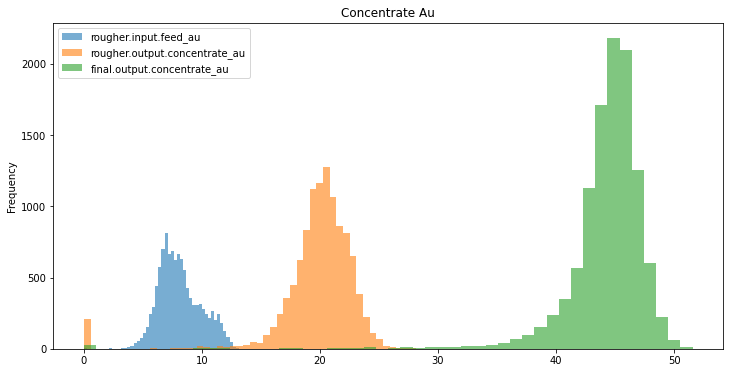

In [ ]:
data_train['rougher.input.feed_au'].plot(kind = 'hist', bins=50, figsize = (12, 6), legend = True, alpha=0.6)
data_train['rougher.output.concentrate_au'].plot(kind = 'hist', bins=50, legend = True, alpha=0.6)
data_train['final.output.concentrate_au'].plot(kind = 'hist', bins=50, legend = True, alpha=0.6)
plt.title('Concentrate Au')

Text(0.5, 0, 'feed_size')

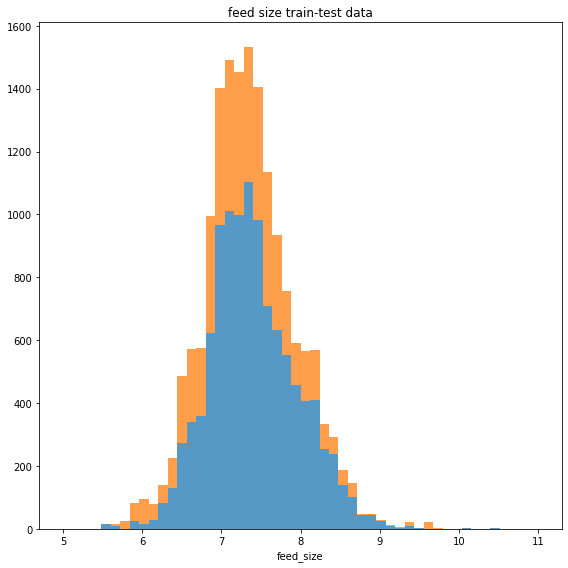

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8), tight_layout=True)

plt.hist([data_train['primary_cleaner.input.feed_size'], data_test['primary_cleaner.input.feed_size']],
            bins = 50, range = (5, 11), alpha=0.75, histtype = 'barstacked')
plt.title('feed size train-test data')
axs.set_xlabel('feed_size')

Text(0.5, 0, 'feed_size')

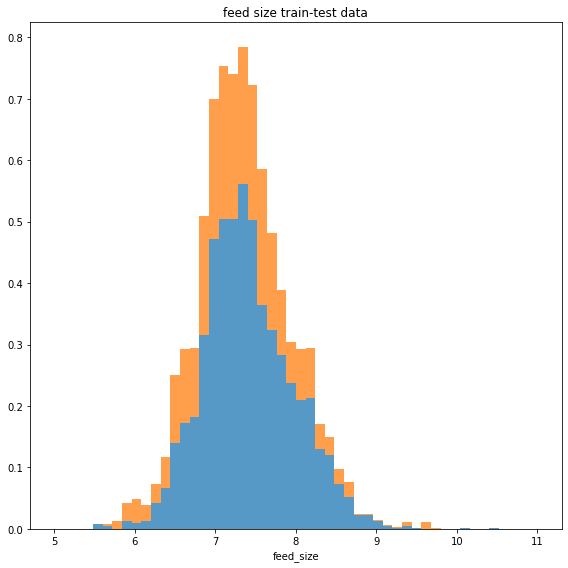

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8), tight_layout=True)

plt.hist([data_train['primary_cleaner.input.feed_size'], data_test['primary_cleaner.input.feed_size']],
            bins = 50, range = (5, 11), alpha=0.75, histtype = 'barstacked', density=True)
plt.title('feed size train-test data')
axs.set_xlabel('feed_size')

Text(0.5, 1.0, 'feed size train-test data')

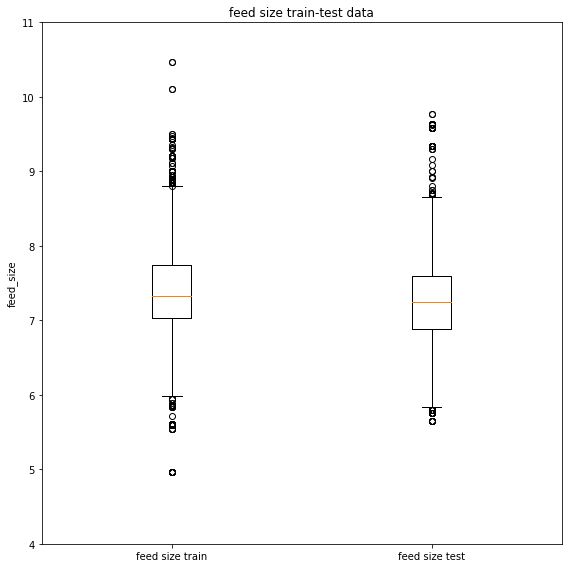

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8), tight_layout=True)

plt.boxplot([data_train['primary_cleaner.input.feed_size'], data_test['primary_cleaner.input.feed_size']], 
            labels = ('feed size train', 'feed size test'))
plt.ylim([4, 11])
axs.set_ylabel('feed_size')
plt.title('feed size train-test data')

Text(0.5, 1.0, 'all concentrate rougher/final')

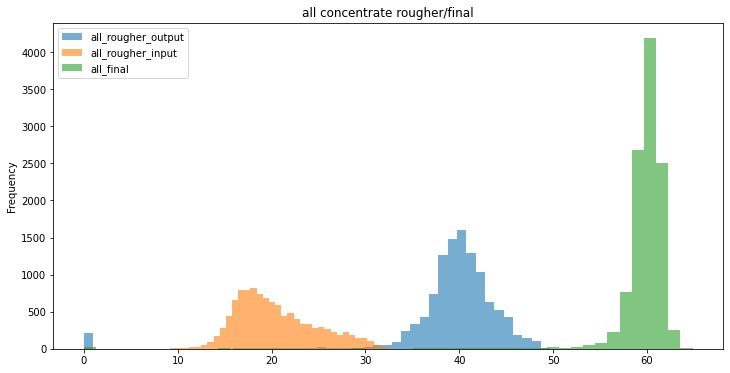

In [ ]:
data_next = pd.DataFrame()
data_next['all_rougher_output'] = (data_train['rougher.output.concentrate_pb'] + data_train['rougher.output.concentrate_au'] + data_train['rougher.output.concentrate_ag'])
data_next['all_rougher_input'] = (data_train['rougher.input.feed_pb'] + data_train['rougher.input.feed_au'] + data_train['rougher.input.feed_ag']) 
data_next['all_final'] = (data_train['final.output.concentrate_pb'] + data_train['final.output.concentrate_au'] + data_train['final.output.concentrate_ag']) 
 
data_next['all_rougher_output'].plot(kind = 'hist', bins=50, figsize = (12, 6), legend = True, alpha=0.6)
data_next['all_rougher_input'].plot(kind = 'hist', bins=50, legend = True, alpha=0.6)
data_next['all_final'].plot(kind = 'hist', bins=50, legend = True, alpha=0.6)
plt.title('all concentrate rougher/final')

In [ ]:
data_train = data_train[((data_next['all_final']) > 0.01) 
                        & (data_next['all_rougher_input'] > 0.01) 
                        & (data_next['all_rougher_output'] > 0.01)]                   

In [ ]:
data_train = data_train[((data_train['rougher.output.concentrate_au']) > 0.01) 
                        & (data_train['rougher.input.feed_au'] > 0.01) 
                        & (data_train['final.output.concentrate_au'] > 0.01)]                   

# Вывод

В результате анализа данных определил что концентрация золота увеличивается на каждой последующей стадии. Концентрация свинца тоже увеличивается а вот концентрация серебра меняется по другому принципу. Распределение похоже на нормальное что выглядит правдоподобно. При этом есть некоторое количество данных сильно отличается, концентрация равна нулю. Можно предположить что это ошибочные данные, поэтому из обучающей выборки исключаем.

## Модель

Нужно написать функцию для вычисления итоговой sMAPE.
Обучить разные модели и оценить их качество кросс-валидацией. Выбрать лучшую модель и проверить её на тестовой выборке.

In [ ]:
def my_custom_loss_func(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rez = 100 * sum(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) / len(y_true) 
    return rez

In [ ]:
score = make_scorer(my_custom_loss_func, greater_is_better=False)

In [ ]:
rougher_columns = []
for l in data_train.columns:
    if 'rougher.input' in l or 'rougher.state' in l:
             rougher_columns.append(l)

In [ ]:
features_rougher = data_train[rougher_columns]
features_final = data_train.drop(delta, axis=1)
features_final = features_final.drop('date', axis=1)
target_final = data_train['final.output.concentrate_au']
target_rougher = data_train['rougher.output.concentrate_au']

Разбил данные на фичи и целевую переменную. С учётом того что требуются предсказания для двух этапов разделил данные по этапам, при этом в первом этапе (флотация) в фичи включил только те данные которые могли бы быть известны на первом этапе. В финальные фичи включил все данные кроме выходных параметров.

In [ ]:
model_r_f_r = RandomForestRegressor()

scores_rougher = cross_val_score(model_r_f_r, features_rougher, target_rougher, cv=5, scoring=score)
scores_final = cross_val_score(model_r_f_r, features_final, target_final, cv=5, scoring=score)
abs(scores_final.mean()), abs(scores_rougher.mean())

(6.8669668864794104, 9.234304609289174)

In [ ]:
model_r_f_r = RandomForestRegressor()
parametrs = { 'n_estimators': range (10, 31, 5),
              'max_depth': range (4, 13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2, 10, 2),
              }
grid_r_f_r = GridSearchCV(model_r_f_r, parametrs, n_jobs = -1, scoring = score, cv=5)
grid_r_f_r.fit(features_rougher, target_rougher)
grid_r_f_r.best_params_, abs(grid_r_f_r.best_score_)

({'max_depth': 12,
  'min_samples_leaf': 7,
  'min_samples_split': 2,
  'n_estimators': 15},
 8.473113370396366)

In [ ]:
model_l_r = LinearRegression()

scores_rougher = cross_val_score(model_l_r, features_rougher, target_rougher, cv=8, scoring=score)
scores_final = cross_val_score(model_l_r, features_final, target_final, cv=8, scoring=score)
abs(scores_final.mean()), abs(scores_rougher.mean())

(5.180387005000451, 7.132165354976872)

In [ ]:
d_t_r = DecisionTreeRegressor()
parametrs = { 'max_depth': range (4, 13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2, 10, 2),
            }
grid_d_t_r = GridSearchCV(d_t_r, parametrs, scoring = score, cv=5)
grid_d_t_r.fit(features_rougher, target_rougher)
grid_d_t_r.best_params_, abs(grid_d_t_r.best_score_)

({'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4},
 8.649274165361714)

In [ ]:
d_t_r = DecisionTreeRegressor()
parametrs = { 'max_depth': range (4, 13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2, 10, 2),
            }
grid_d_t_r = GridSearchCV(d_t_r, parametrs, scoring = score, cv=5)
grid_d_t_r.fit(features_final, target_final)
grid_d_t_r.best_params_, abs(grid_d_t_r.best_score_)

({'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 4},
 5.35641513745489)

После проверки моделей методом кросвалидации по заданной функции ошибки можно сделать вывод что наименьшая ошибка у линейной регрессии.


In [ ]:
best_model_rougher = LinearRegression()
best_model_final = LinearRegression()
best_model_rougher.fit(features_rougher, target_rougher)
best_model_final.fit(features_final, target_final)


LinearRegression()

In [ ]:
data_test = data_test.set_index('date')
data_full = data_full.set_index('date')

data_valid = data_full.loc[data_test.index]

In [ ]:
data_valid.isnull().sum().sum()

381

In [ ]:
data_valid = data_valid.dropna()

Подготовил данные для валидации. По дате (уникальный идентификатор) из общей выборки получил фичи. Разбил выборки аналогично предидущему этапу. Удалил строки с пропущенными значениями.

In [ ]:
features_rougher_val = data_valid[rougher_columns]
features_final_val = data_valid.drop(delta, axis=1, errors = 'ignore')
target_final_val = data_valid['final.output.concentrate_au']
target_rougher_val = data_valid['rougher.output.concentrate_au']

In [ ]:
roug_pred = best_model_rougher.predict(features_rougher_val)
fin_pred = best_model_final.predict(features_final_val)

'Итоговое sMAPE:', (0.25 * my_custom_loss_func(roug_pred, target_rougher_val)) + (0.75 * my_custom_loss_func(fin_pred, target_final_val))


('Итоговое sMAPE:', 7.000722817120868)

# Вывод:

Мною было проверено несколько моделей. Лучше всего показала себя линейная регрессия -  для заданной метрики (sMAPE) ошибка была самой маленькой. Лучшая модель была обучена для предсказания искомых значений, каждая на своём наборе данных. Итоговое значение sMAPE, посчитанное по формуле 25% * sMAPE(rougher) + 75% * sMAPE(final) показало результат 7%.